In [1]:
#% shift enter to run section
#% Place cursors where the split is desired, and then press and release ctrl + shift + -
#% Multiple cursors may be placed, by holding ctrl, and clicking the location for the cursor
#% Select the desired, consecutive cells, by holding shift, and clicking in the margin, where the [ ] is, which will highlight the selected cells.
#% While still holding shift, press m, and then release both keys.
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import numpy as np
import numpy.ma as ma
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use('ggplot')
import xarray as xr
from glob import glob
import netCDF4
from netCDF4 import Dataset
import matplotlib.mlab as mlab
import pylab
import pyreadr
import seaborn as sns
import tqdm
import tzlocal
import sys
import os
import scipy.interpolate as sc
from scipy import signal
my_timezone = tzlocal.get_localzone().zone
# pylab for more MATLAB like environment and inline displays plots below cells
%pylab inline

# if gsw Warning shows, manually install gsw if possible - will still work without
import glidertools as gt
from cmocean import cm as cmo  # we use this for colormaps
#del()
import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats 
import scipy.stats   
from skgstat import Variogram
import pykrige

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from sklearn.linear_model import LinearRegression
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

Populating the interactive namespace from numpy and matplotlib


C:\Users\Sean Evans\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load data
Remember to insert the seal id number to read in data for that seal

In [3]:
dives_pdsi=readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/dives_pdsi.rds')
dives_pdsi = pandas2ri.ri2py(dives_pdsi)

C:\Users\Sean Evans\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



In [4]:
#%store -r flr_gridded_xdsw
#%store -r flr_gridded_xdse
%store -r flr_gridded_xdsw
%store -r flr_gridded_xdse

In [5]:
SealIDS = np.array([1,2,4,5,13,14,15,16,17,18,19,20,21,22,23,24,25,31,47,49,50,51,52,53,57,58,62,63,64,65,66,67,68,69,70,109,110,112,113]).astype(int)
summer = [13,14,15,16,20,21,22,23,52,53,57,58,63,64,65,66,67,110,112,113]
West_summer = [21,22,52,53,57,58,63,64,65,66,67,113]
East_summer = [13,14,15,16,20,21,22,23,58,63,110,112]
West_mostly_summer = [52,53,57,58,63,64,65,66,67,113]
East_mostly_summer = [13,14,15,16,20,21,22,23,110,112]
winter = [1,2,4,5,17,18,19,24,25,31,47,49,50,51,62,68,69,70,109]
West_mostly_winter = [4,5,25,31,47,49,50,51,62,68,69,70,109]
East_mostly_winter = [1,2,17,18,19,24]
#West_winter = [1,2,5,17,18,19,24,25,31,109]
#East_winter = [4,5,25,31,50 #19 - many dives on east as well, 

## Loop all seals

# Updated 

In [24]:
# dives_pdsi removed dives with Time and num
### West seals ### Should I use west dives rather using sealID and divenumber
# Each seal is read in and appended
#del(g)
#del(flr_gridded_xdsw)

diving=readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/diving.rds')
diving = pandas2ri.ri2py(diving)
for f in tqdm_notebook(list(range(len(SealIDS)))):
    number = SealIDS[f]
    
    print(number)
    #if sealID in winter
    if number in winter:
        if f==0:
            flr_gridded_xds = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
            dives_ = diving[(diving.sealID==str(number))]
            bsm_seg_df = readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/bsm_seg_df/'+str(number)+'_bsm_seg_df.rds')
            bsm_seg_df = pandas2ri.ri2py(bsm_seg_df)
            
            Time = flr_gridded_xds.Time.astype('datetime64[s]').values
            flr_gridded_xds = flr_gridded_xds.assign_coords(num=('Time',bsm_seg_df.num.unique()))
            flr_gridded_xds = flr_gridded_xds.swap_dims({'Time': 'num'})

            flr_gridded_xds=flr_gridded_xds.sel(num=dives_.num.values)
            sid = repeat(number,len(flr_gridded_xds.num))
            yr = dives_.year.values.astype(int)
            lat = dives_.lat.values.astype(float)
            lon = dives_.lon.values.astype(float)
            we = dives_.WE.values
            WEseal = repeat('East',len(flr_gridded_xds.num))
            season = dives_.season.values
            ft = dives_.ft.values
            flr_gridded_xds = flr_gridded_xds.assign_coords(sealID=('num',sid))
            flr_gridded_xds = flr_gridded_xds.assign_coords(year=('num',yr))
            flr_gridded_xds = flr_gridded_xds.assign_coords(lat=('num',lat))
            flr_gridded_xds = flr_gridded_xds.assign_coords(lon=('num',lon))
            flr_gridded_xds = flr_gridded_xds.assign_coords(we=('num',we))
            flr_gridded_xds = flr_gridded_xds.assign_coords(WEseal=('num',WEseal))
            flr_gridded_xds = flr_gridded_xds.assign_coords(season=('num',season))
            flr_gridded_xds = flr_gridded_xds.assign_coords(ft=('num',ft))


            
        else:
            if number in West_mostly_winter:
                flr_gridded_xds1 = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
                dives_ = diving[(diving.sealID==str(number))]
                bsm_seg_df = readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/bsm_seg_df/'+str(number)+'_bsm_seg_df.rds')
                bsm_seg_df = pandas2ri.ri2py(bsm_seg_df)
            
                Time = flr_gridded_xds1.Time.astype('datetime64[s]').values
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(num=('Time',bsm_seg_df.num.unique()))
                flr_gridded_xds1 = flr_gridded_xds1.swap_dims({'Time': 'num'})

                flr_gridded_xds1=flr_gridded_xds1.sel(num=dives_.num.values)
                sid = repeat(number,len(flr_gridded_xds1.num))
                yr = dives_.year.values.astype(int)
                lat = dives_.lat.values.astype(float)
                lon = dives_.lon.values.astype(float)
                we = dives_.WE.values
                WEseal = repeat('West',len(flr_gridded_xds1.num))
                season = dives_.season.values
                ft = dives_.ft.values
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(sealID=('num',sid))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(year=('num',yr))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lat=('num',lat))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lon=('num',lon))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(we=('num',we))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(WEseal=('num',WEseal))   
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(season=('num',season))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(ft=('num',ft))
                flr_gridded_xds = xr.concat((flr_gridded_xds,flr_gridded_xds1),dim='num')

            if number in East_mostly_winter:
                flr_gridded_xds1 = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
                dives_ = diving[(diving.sealID==str(number))]
                bsm_seg_df = readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/bsm_seg_df/'+str(number)+'_bsm_seg_df.rds')
                bsm_seg_df = pandas2ri.ri2py(bsm_seg_df)
            
                Time = flr_gridded_xds1.Time.astype('datetime64[s]').values
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(num=('Time',bsm_seg_df.num.unique()))
                flr_gridded_xds1 = flr_gridded_xds1.swap_dims({'Time': 'num'})

                flr_gridded_xds1=flr_gridded_xds1.sel(num=dives_.num.values)
                sid = repeat(number,len(flr_gridded_xds1.num))
                yr = dives_.year.values.astype(int)
                lat = dives_.lat.values.astype(float)
                lon = dives_.lon.values.astype(float)
                we = dives_.WE.values
                WEseal = repeat('East',len(flr_gridded_xds1.num))
                season = dives_.season.values
                ft = dives_.ft.values
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(sealID=('num',sid))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(year=('num',yr))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lat=('num',lat))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lon=('num',lon))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(we=('num',we))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(WEseal=('num',WEseal)) 
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(season=('num',season))
                flr_gridded_xds1 = flr_gridded_xds1.assign_coords(ft=('num',ft))
                flr_gridded_xds = xr.concat((flr_gridded_xds,flr_gridded_xds1),dim='num')
                
    if number in summer:
        if number in West_mostly_summer:
            flr_gridded_xds1 = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
            dives_ = diving[(diving.sealID==str(number))]
            bsm_seg_df = readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/bsm_seg_df/'+str(number)+'_bsm_seg_df.rds')
            bsm_seg_df = pandas2ri.ri2py(bsm_seg_df)
            
            Time = flr_gridded_xds1.Time.astype('datetime64[s]').values
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(num=('Time',bsm_seg_df.num.unique()))
            flr_gridded_xds1 = flr_gridded_xds1.swap_dims({'Time': 'num'})

            flr_gridded_xds1=flr_gridded_xds1.sel(num=dives_.num.values)
            sid = repeat(number,len(flr_gridded_xds1.num))
            yr = dives_.year.values.astype(int)
            lat = dives_.lat.values.astype(float)
            lon = dives_.lon.values.astype(float)
            we = dives_.WE.values
            WEseal = repeat('West',len(flr_gridded_xds1.num))
            season = dives_.season.values
            ft = dives_.ft.values
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(sealID=('num',sid))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(year=('num',yr))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lat=('num',lat))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lon=('num',lon))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(we=('num',we))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(WEseal=('num',WEseal))   
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(season=('num',season))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(ft=('num',ft))
            flr_gridded_xds = xr.concat((flr_gridded_xds,flr_gridded_xds1),dim='num')

        if number in East_mostly_summer:
            flr_gridded_xds1 = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
            dives_ = diving[(diving.sealID==str(number))]
            bsm_seg_df = readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/bsm_seg_df/'+str(number)+'_bsm_seg_df.rds')
            bsm_seg_df = pandas2ri.ri2py(bsm_seg_df)
            
            Time = flr_gridded_xds1.Time.astype('datetime64[s]').values
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(num=('Time',bsm_seg_df.num.unique()))
            flr_gridded_xds1 = flr_gridded_xds1.swap_dims({'Time': 'num'})

            flr_gridded_xds1=flr_gridded_xds1.sel(num=dives_.num.values)
            sid = repeat(number,len(flr_gridded_xds1.num))
            yr = dives_.year.values.astype(int)
            lat = dives_.lat.values.astype(float)
            lon = dives_.lon.values.astype(float)
            we = dives_.WE.values
            WEseal = repeat('East',len(flr_gridded_xds1.num))
            season = dives_.season.values
            ft = dives_.ft.values
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(sealID=('num',sid))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(year=('num',yr))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lat=('num',lat))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(lon=('num',lon))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(we=('num',we))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(WEseal=('num',WEseal)) 
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(season=('num',season))
            flr_gridded_xds1 = flr_gridded_xds1.assign_coords(ft=('num',ft))
            flr_gridded_xds = xr.concat((flr_gridded_xds,flr_gridded_xds1),dim='num')
                
flr_gridded_xds.coords['Time'] = flr_gridded_xds.Time.astype('datetime64[s]')
flr_gridded_xds = flr_gridded_xds.swap_dims({'num': 'Time'})

C:\Users\Sean Evans\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



1
2
4
5
13
14
15
16
17
18
19
20
21
22
23
24
25
31
47
49
50
51
52
53
57
58
62
63
64
65
66
67
68
69
70
109
110
112
113



## Saving and storing Xarray to netcdf

In [7]:
midx = pd.MultiIndex.from_arrays([flr_gridded_xds.Time.values,flr_gridded_xds.num.values,flr_gridded_xds.sealID.values,flr_gridded_xds.year.values,flr_gridded_xds.lat.values,flr_gridded_xds.lon.values,flr_gridded_xds.we.values,flr_gridded_xds.WEseal.values,flr_gridded_xds.season.values,flr_gridded_xds.ft.values], names=("Time","num","sealID","year","lat","lon","we","WEseal","season","ft"))
All_T_profiles=xr.DataArray(flr_gridded_xds.values, [("depths", flr_gridded_xds.depths),("x", midx)])

In [4]:
All_T_profiles

<xarray.DataArray (depths: 200, Time: 343200)>
array([[5.3 , 5.55, 5.55, ...,  nan,  nan, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * depths   (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * Time     (Time) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T01:21:21 ...
    num      (Time) float64 82.0 88.0 102.0 108.0 110.0 112.0 114.0 116.0 ...
    sealID   (Time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    year     (Time) int32 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
    lat      (Time) float64 -47.28 -47.28 -47.31 -47.52 -47.52 -47.52 -47.52 ...
    lon      (Time) float64 38.24 38.24 38.3 38.46 38.46 38.46 38.46 38.46 ...
    we       (Time) object 'East' 'East' 'East' 'East' 'East' 'East' '

In [ ]:
All_T_profiles = flr_gridded_xds
%store All_T_profiles
%store flr_gridded_xds
All_T_profiles.to_netcdf('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/netcdf/All_T_profiles.nc')

In [2]:
%store -r All_T_profiles
%store -r flr_gridded_xds

In [3]:
midx = pd.MultiIndex.from_arrays([flr_gridded_xds.Time.values,flr_gridded_xds.num.values,flr_gridded_xds.sealID.values,flr_gridded_xds.year.values,flr_gridded_xds.lat.values,flr_gridded_xds.lon.values,flr_gridded_xds.we.values,flr_gridded_xds.WEseal.values,flr_gridded_xds.season.values,flr_gridded_xds.ft.values], names=("Time","num","sealID","year","lat","lon","we","WEseal","season","ft"))
All_T_profiles=xr.DataArray(flr_gridded_xds.values, [("depths", flr_gridded_xds.depths),("x", midx)])
All_T_profiles

<xarray.DataArray (depths: 200, x: 343200)>
array([[5.3 , 5.55, 5.55, ...,  nan,  nan, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * depths   (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * x        (x) MultiIndex
  - Time     (x) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T01:21:21 ...
  - num      (x) float64 82.0 88.0 102.0 108.0 110.0 112.0 114.0 116.0 118.0 ...
  - sealID   (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - year     (x) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
  - lat      (x) float64 -47.28 -47.28 -47.31 -47.52 -47.52 -47.52 -47.52 ...
  - lon      (x) float64 38.24 38.24 38.3 38.46 38.46 38.46 38.46 38.46 ...
  - we       (x) object 'East' 'East' 'East' 'East' '

In [6]:
All_T_profiles.coords

Coordinates:
  * depths   (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * x        (x) MultiIndex
  - Time     (x) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T01:21:21 ...
  - num      (x) float64 82.0 88.0 102.0 108.0 110.0 112.0 114.0 116.0 118.0 ...
  - sealID   (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - year     (x) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
  - lat      (x) float64 -47.28 -47.28 -47.31 -47.52 -47.52 -47.52 -47.52 ...
  - lon      (x) float64 38.24 38.24 38.3 38.46 38.46 38.46 38.46 38.46 ...
  - we       (x) object 'East' 'East' 'East' 'East' 'East' 'East' 'East' ...
  - WEseal   (x) object 'East' 'East' 'East' 'East' 'East' 'East' 'East' ...
  - season   (x) object 'winter' 'winter' 'winter' 'winter' 'winter' ...
  - ft       (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...

### Temperature profiles

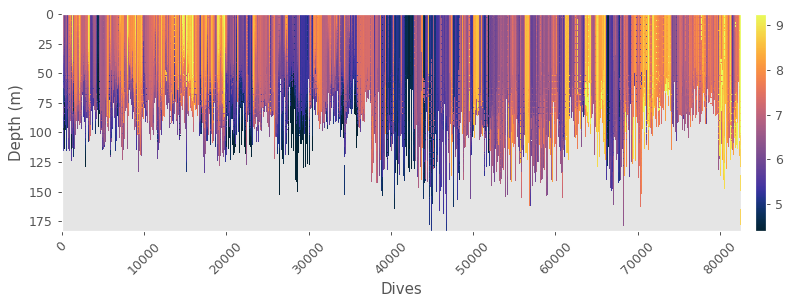

In [13]:
#gt.plot.pcolormesh(flr_gridded_xds.values, cmap=cmo.thermal)
#masked_df = np.ma.masked_where(np.isnan(flr_gridded_xds),flr_gridded_xds)
gt.plot.pcolormesh(masked_df, cmap=cmo.thermal)

### Re-index 

In [174]:
#plot(flr_gridded_xds1.lat.values)
#plot(flr_gridded_xds1.lon.values)

In [137]:
All_T_profiles

<xarray.DataArray (depths: 200, x: 343200)>
array([[5.3 , 5.55, 5.55, ...,  nan,  nan, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       [5.3 , 5.55, 5.55, ...,  nan, 9.45, 9.7 ],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * depths   (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * x        (x) MultiIndex
  - Time     (x) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T01:21:21 ...
  - num      (x) float64 82.0 88.0 102.0 108.0 110.0 112.0 114.0 116.0 118.0 ...
  - sealID   (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - year     (x) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
  - lat      (x) float64 -47.28 -47.28 -47.31 -47.52 -47.52 -47.52 -47.52 ...
  - lon      (x) float64 38.24 38.24 38.3 38.46 38.46 38.46 38.46 38.46 ...
  - we       (x) object 'East' 'East' 'East' 'East' '

In [7]:
print(All_T_profiles.sortby('Time').sel(sealID=1).Time.values[0:10])
print(All_T_profiles.sel(sealID=1).Time.values[0:10])

['2009-04-30T00:25:46.000000000' '2009-04-30T01:21:21.000000000'
 '2009-04-30T03:31:10.000000000' '2009-04-30T15:16:14.000000000'
 '2009-04-30T15:26:01.000000000' '2009-04-30T15:32:30.000000000'
 '2009-04-30T15:42:35.000000000' '2009-04-30T15:47:38.000000000'
 '2009-04-30T15:52:53.000000000' '2009-04-30T15:58:19.000000000']
['2009-04-30T00:25:46.000000000' '2009-04-30T01:21:21.000000000'
 '2009-04-30T03:31:10.000000000' '2009-04-30T15:16:14.000000000'
 '2009-04-30T15:26:01.000000000' '2009-04-30T15:32:30.000000000'
 '2009-04-30T15:42:35.000000000' '2009-04-30T15:47:38.000000000'
 '2009-04-30T15:52:53.000000000' '2009-04-30T15:58:19.000000000']


## Create b_init_groups

In [6]:
# Make sure profiles are ordered in Time
for seal in tqdm_notebook(list(range(len(SealIDS)))):
    number=SealIDS[seal]
    print(number)
    if (seal==0) :
        lat = np.array(All_T_profiles.sortby('Time').sel(sealID=number)['lat'])*-1
        lon = np.array(All_T_profiles.sortby('Time').sel(sealID=number)['lon'])
        dist_trav = np.r_[gt.utils.distance(lon, lat).cumsum()]/1000
        dist_between = (np.r_[gt.utils.distance(lon, lat),0]/1000)[1:]
        sid = repeat(number,len(lat))
        b_init_groups = All_T_profiles.sortby('Time').sel(sealID=number).assign_coords(dist_trav=("x", dist_trav)).assign_coords(sealID=('x',sid))
    else:
        lat = np.array(All_T_profiles.sortby('Time').sel(sealID=number)['lat'])*-1
        lon = np.array(All_T_profiles.sortby('Time').sel(sealID=number)['lon'])
        dist_trav = np.r_[gt.utils.distance(lon, lat).cumsum()]/1000
        dist_between = (np.r_[gt.utils.distance(lon, lat),0]/1000)[1:]
        sid = repeat(number,len(lat))
        b_init_groups1 = All_T_profiles.sortby('Time').sel(sealID=number).assign_coords(dist_trav=("x", dist_trav)).assign_coords(sealID=('x',sid))
        b_init_groups = xr.concat((b_init_groups,b_init_groups1),dim='x')

1
2
4
5
13
14
15
16
17
18
19
20
21
22
23
24
25
31
47
49
50
51
52
53
57
58
62
63
64
65
66
67
68
69
70
109
110
112
113



In [7]:
new_df = np.r_['1',b_init_groups[:,1:],np.expand_dims(repeat(np.nan,200),1)]
mid_x = pd.MultiIndex.from_arrays([b_init_groups.Time.values,b_init_groups.num.values,b_init_groups.sealID.values,b_init_groups.year.values,b_init_groups.lat.values,b_init_groups.lon.values,b_init_groups.we.values,b_init_groups.WEseal.values,b_init_groups.season.values,b_init_groups.ft.values,b_init_groups.dist_trav], names=("Time","num","sealID","year","lat","lon","we","WEseal","season","ft","dist_trav"))
new_df=xr.DataArray(new_df, [("depths", b_init_groups.depths.values),("x", mid_x)])
new_df

<xarray.DataArray (depths: 200, x: 343200)>
array([[5.55, 5.55, 5.6 , ...,  nan,  nan,  nan],
       [5.55, 5.55, 5.6 , ...,  nan,  nan,  nan],
       [5.55, 5.55, 5.6 , ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * depths     (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * x          (x) MultiIndex
  - Time       (x) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T01:21:21 ...
  - num        (x) float64 82.0 88.0 102.0 108.0 110.0 112.0 114.0 116.0 ...
  - sealID     (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - year       (x) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
  - lat        (x) float64 -47.28 -47.28 -47.31 -47.52 -47.52 -47.52 -47.52 ...
  - lon        (x) float64 38.24 38.24 38.3 38.46 38.46 38.46 38.46 38.46 ...
  - we         (x) object 'East' 'East' 'East' 'Ea

In [8]:
#For all seals (Not computed seal-by-seal)
lat = np.array(.['lat'])*-1
lon = np.array(All_T_profiles['lon'])
dist_trav = np.r_[gt.utils.distance(lon, lat).cumsum()]/1000
dist_between = (np.r_[gt.utils.distance(lon, lat),0]/1000)[1:]
#b_init_groups = All_T_profiles.assign_coords(dist_between=("x", dist_between))
b_init_groups = All_T_profiles.assign_coords(dist_trav=("x", dist_trav))

# Loop for hbg 

In [84]:
seal_df = new_df.sel(sealID=1).sel(season='winter')
longitudes = seal_df.lon.groupby('dist_trav').min()
Start = seal_df.Time.groupby('dist_trav').max()
ft = seal_df.ft.groupby('dist_trav').min()
hbg_init = seal_df.groupby('dist_trav').reduce(nanmean,dim='x').assign_coords(longitudes=('dist_trav',longitudes)).assign_coords(Start=('dist_trav',Start)).assign_coords(ft=('dist_trav',ft)).sortby(Start)
mid = pd.MultiIndex.from_arrays([hbg_init.Start.values,hbg_init.ft.values,hbg_init.longitudes.values,hbg_init.dist_trav.values], names=("Start","ft","longitudes","dist_trav"))
hbg_init=xr.DataArray(hbg_init.values, [("depths", hbg_init.depths.values),("x", mid),])

In [85]:
hbg_init

<xarray.DataArray (depths: 200, x: 108)>
array([[5.55    , 5.6     , 5.5625  , ..., 5.45    , 5.440741, 5.475   ],
       [5.55    , 5.6     , 5.5625  , ..., 5.45    , 5.440741, 5.475   ],
       [5.55    , 5.6     , 5.5625  , ..., 5.45    , 5.440741, 5.475   ],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * depths      (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * x           (x) MultiIndex
  - Start       (x) datetime64[ns] 2009-04-30T01:21:21 2009-04-30T03:31:10 ...
  - ft          (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - longitudes  (x) float64 38.24 38.3 38.46 38.44 38.44 38.45 38.5 38.45 ...
  - dist_trav   (x) float64 0.0 6.317 32.5 34.68 40.2 44.37 50.77 61.79 ...

In [56]:
np.median(diff(hbg_init.Start.sel(ft=1))/1e9/60)

numpy.timedelta64(138,'ns')

In [23]:
((diff(hbg_init.Start.sel(ft=6))/1e9/60).astype(int))[((diff(hbg_init.Start.sel(ft=6))/1e9/60).astype(int))>100]
max_Start_diff = max((diff(hbg_init.Start.sel(ft=6))/1e9/60).astype(int))
max_dist_diff = max(diff(hbg_init.dist_trav.sel(ft=6)))

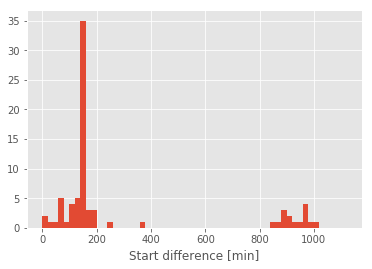

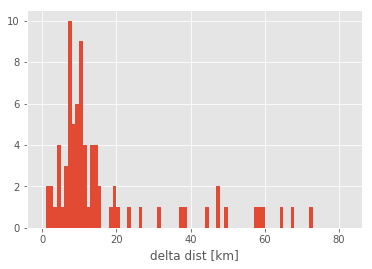

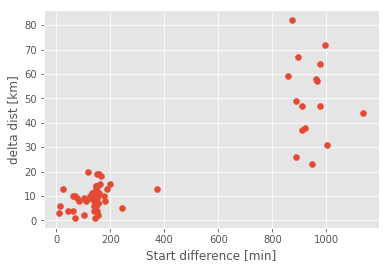

In [24]:
plt.hist((diff(hbg_init.Start.sel(ft=6))/1e9/60),arange(0,max_Start_diff,20))
plt.xlabel('Start difference [min]')
plt.show()
plt.hist(diff(hbg_init.dist_trav.sel(ft=6)),arange(0,max_dist_diff,1))
plt.xlabel('delta dist [km]')
plt.show()
plt.scatter((diff(hbg_init.Start.sel(ft=6))/1e9/60).astype(int),diff(hbg_init.dist_trav.sel(ft=6)).astype(int))
plt.xlabel('Start difference [min]')
plt.ylabel('delta dist [km]')
plt.show()

In [122]:
print(diff(new_df.Time.sel(sealID=113).sel(ft=5).groupby('dist_trav').reduce(nanmax,axis=0))/1e9/3600)
print(diff(new_df.dist_trav.sel(sealID=113).sel(ft=5).groupby('dist_trav').reduce(nanmin,axis=0)))

[   0    0   44  506 -503    0  503 -481  481 -478   17  460 -455  455
 -435  435 -431    0    0   22   18    0  389 -383    0   18    2    3
  359 -339  339 -336   19    1    3    0  312 -292  292 -287    0    0
    0   16    0]
[  1.73130313   7.03556224   3.49624583   4.50455144   7.36471648
  20.36648983   3.67712114   2.08611981   4.50725035   6.96046356
   2.6308185    1.74320085   0.73610196   8.77234243   4.38335684
   3.62402357   4.6491455   78.59231632  11.91861461  34.49709689
 125.31044642  27.79830721  26.27753746  12.17545237  21.6530582
   3.38801392  17.97564234  12.41159937  32.02081032   3.55252592
   7.18858778   5.06705409  15.83279687   6.77978195   8.03455084
   7.95160889  33.47965094   5.54536092   4.48868434   3.28674636
  22.72752726   5.3231593    5.73886064   4.40238175   2.80648469]


In [38]:
############ Calculating HBG ########## 

def calc_hbg(var,g = 9.8,alpha = -0.000125):

    """Calculate hbg

    Args:
      var: Temperature 

    Return:
        hbg for each profile and at each depth based on lateral temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    hbg=[]
    hbg_mean = []

    try:
        T_diff = diff(var)/diff(dpt)
        Hbg = T_diff*(g*alpha)
        hbg += Hbg,
        hbg_mean = np.nanmean(Hbg)
    except:
        hbg += np.NaN,
        hbg_mean = np.NaN

    return np.array(hbg,hbg_mean)

In [273]:
diving=readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/diving.rds')
diving = pandas2ri.ri2py(diving)
for s in tqdm_notebook(list(range(len(SealIDS)))):
    number = SealIDS[s]

    print(number)
    try:
        if max(new_df.sel(sealID=number).ft.values)==1:
            f=1
            seal_df = new_df.sel(sealID=number).sel(ft=f).sortby('Time')#.sel(season='winter')
            longitudes = seal_df.lon.groupby('dist_trav').min()
            Start = seal_df.Time.groupby('dist_trav').min()
            ft = repeat(f,len(Start))
            hbg_init = seal_df.groupby('dist_trav').reduce(nanmean,dim='x').assign_coords(longitudes=('dist_trav',longitudes)).assign_coords(Start=('dist_trav',Start)).assign_coords(ft=('dist_trav',ft)).sortby(Start)
            mid = pd.MultiIndex.from_arrays([hbg_init.Start.values,hbg_init.ft.values,hbg_init.longitudes.values,hbg_init.dist_trav.values], names=("Start","ft","longitudes","dist_trav"))
            hbg_init=xr.DataArray(hbg_init.values, [("depths", hbg_init.depths.values),("x", mid)])

            if s==0:
                if hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number))]
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })

                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('West',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg=xr.DataArray(hbg.values, [("depths", hbg.depths.values),("x", mid),])

                if hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number))]
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })

                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('East',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg=xr.DataArray(hbg.values, [("depths", hbg.depths.values),("x", mid),])

            else:
                if hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number))]
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg1 = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })

                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('West',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg1.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg1=xr.DataArray(hbg1.values, [("depths", hbg1.depths.values),("x", mid),])
                    hbg = xr.concat((hbg,hbg1),dim='x')

                if hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number))]
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg1 = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })
            
                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('East',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg1.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg1=xr.DataArray(hbg1.values, [("depths", hbg1.depths.values),("x", mid),])
                    hbg = xr.concat((hbg,hbg1),dim='x')
                    
        else:
            for g in tqdm_notebook(list(range(max(new_df.sel(sealID=number).ft.values)))):
                flist = arange(1,max(new_df.sel(sealID=number).ft.values)+1,1)
                for_trip = flist[g]
                seal_df = new_df.sel(sealID=number).sel(ft=for_trip).sortby('Time')#.sel(season='winter')
                longitudes = seal_df.lon.groupby('dist_trav').min()
                Start = seal_df.Time.groupby('dist_trav').min()
                ft = repeat(for_trip,len(Start))
                hbg_init = seal_df.groupby('dist_trav').reduce(nanmean,dim='x').assign_coords(longitudes=('dist_trav',longitudes)).assign_coords(Start=('dist_trav',Start)).assign_coords(ft=('dist_trav',ft)).sortby(Start)
                mid = pd.MultiIndex.from_arrays([hbg_init.Start.values,hbg_init.ft.values,hbg_init.longitudes.values,hbg_init.dist_trav.values], names=("Start","ft","longitudes","dist_trav"))
                hbg_init=xr.DataArray(hbg_init.values, [("depths", hbg_init.depths.values),("x", mid)])
    

                if hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes<37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number)) & (diving.ft==for_trip)] 
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg1 = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })
            
                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('East',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg1.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg1=xr.DataArray(hbg1.values, [("depths", hbg1.depths.values),("x", mid),])
                    hbg = xr.concat((hbg,hbg1),dim='x')
        
                if hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start').values.size>0:
                    hbg_ = hbg_init.where(hbg_init.longitudes>=37.736, drop=True).sortby('Start')
                    dives_ = diving[(diving.sealID==str(number)) & (diving.ft==for_trip)]
                    dpt = hbg_.dist_trav.values
                    hbg_pre = np.apply_along_axis(calc_hbg,1,hbg_)
                    hbg_pre = hbg_pre.squeeze()
                    hbg1 = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                                coords={"depths":arange(1,201,1),
                                "delta_x": diff(dpt)                                     
                                })
            
                    sid = repeat(number,len(hbg_.Start))
                    we = repeat('East',len(hbg_.Start))         
                    season = repeat(dives_.season.values[0],len(hbg_.Start))
                    year = repeat(dives_.year.values[0],len(hbg_.Start))

                    mid = pd.MultiIndex.from_arrays([np.delete(hbg_.Start,-1),np.delete(hbg_.ft,-1),np.delete(hbg_.longitudes,-1)
                                                    ,np.delete(hbg_.dist_trav,-1),hbg1.delta_x,np.delete(sid,-1),np.delete(we,-1)
                                                    ,np.delete(season,-1),np.delete(year,-1)],
                                                    names=("Start","ft","longitudes","dist_trav",'delta_x','sealID','we','season','year'))
                    hbg1=xr.DataArray(hbg1.values, [("depths", hbg1.depths.values),("x", mid),])
                    hbg = xr.concat((hbg,hbg1),dim='x')
    except:
        print(number)
        pass

C:\Users\Sean Evans\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



1
2
4
5


13


14


15


16


17
18


19


20


21


22


23


24


25


31


47


49


50


51


52


53


57


58


58
62


63


64


65


66


66
67


67
68


69


70


109


110


112


113


113


In [281]:
hbg

<xarray.DataArray (depths: 200, x: 13722)>
array([[-9.696811e-06,  1.754647e-06, -1.792824e-05, ...,  3.050501e-03,
         2.669995e-04,           nan],
       [-9.696811e-06,  1.754647e-06, -1.792824e-05, ...,  2.819652e-03,
         2.697239e-04,  7.967771e-05],
       [-9.696811e-06,  1.754647e-06, -1.792824e-05, ..., -9.000352e-04,
         3.734814e-04,  7.906715e-05],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * depths      (depths) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x           (x) MultiIndex
  - Start       (x) datetime64[ns] 2009-04-30T00:25:46 2009-04-30T03:31:10 ...
  - ft          (x) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

## West dives hbg

In [235]:
dpt = b_init.dist_between.values
hbg_pre = np.apply_along_axis(calc_hbg,1,b_init)
hbg_pre = hbg_pre.squeeze()
print(hbg_pre)

[[            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...  7.32673029e-06
  -2.79692211e-05             nan]
 [            nan             nan             nan ...  7.32673029e-06
  -2.79692211e-05             nan]
 ...
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]]


In [246]:
hbg = xr.DataArray(data=hbg_pre,dims=["depths","delta_x"],
                    coords={"depths":arange(1,201,1),
                    "delta_x": np.delete(b_init.dist_between.values,0)                                     
                    })
#hbg = xr.DataArray(data=hbg_pre,dims=["depths","dist_trav"],
#                    coords={"depths":arange(1,201,1),
#                    "dist_trav": np.delete(b_init.dist_trav.values,0)                                     
#                    })

hbg_ = abs(hbg[9])
print(hbg.count(axis=1).values)

[ 199  356  537  776 1022 1234 1342 1368 1382 1390 1404 1400 1384 1378
 1370 1359 1354 1359 1350 1345 1348 1344 1336 1329 1330 1320 1306 1298
 1269 1248 1218 1201 1182 1155 1128 1109 1058 1024  992  960  906  859
  816  781  743  695  645  612  574  537  498  458  428  386  358  333
  320  293  274  248  224  210  183  175  159  143  136  130  119  103
   92   93   86   83   80   75   69   62   60   61   58   53   50   43
   37   36   35   34   29   23   24   23   19   19   18   15   15   13
   14   14   14   14   13   11   10    8    8    8    8    7    5    4
    2    2    1    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### delta_x distribution

(array([273., 321., 186., 120.,  98., 101.,  53.,  44.,  27.,  21.,  16.,
         12.,  12.,  17.,  16.,   9.,  14.,   6.,   7.,   3.,   9.,  10.,
          1.,   6.,   9.,   5.,   5.,   5.,   3.,   2.,   4.,   4.,   1.,
          2.,   3.,   1.,   2.,   1.,   1.,   2.,   0.,   0.,   2.,   3.,
          2.,   0.,   1.,   0.,   1.,   3.,   0.,   0.,   2.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([4.42796996e-02, 2.42956804e+00, 4.81485639e+00, 7.20014473e+00,
        9.58543307e+00, 1.19707214e+01, 1.43560098e+01, 1.67412981e+01,
        1.91265864e+01, 2.15118748e+01, 2.38971631e+01, 2.62824515e+01,
        2.86677398e+01, 3.10530282e+01, 3.34383165e+01, 3.58236048e+01,
        3.82088932e+01, 4.0594

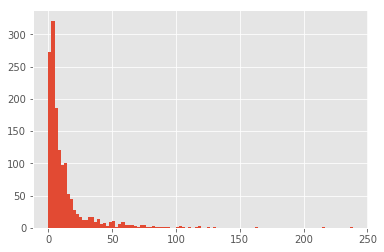

In [215]:
hist(hbg.sel(delta_x=slice(0,50000)).delta_x.values, bins=100)
#hist(b_init.sel(dist_between=slice(0,50000)).dist_between.values, bins=100)

In [240]:
#gt.plot.pcolormesh(abs(hbg.sel(delta_x=slice(0,50000))), cmap=cmo.balance, vmin=-0.02,vmax=0.02)
#gt.plot.pcolormesh(hbg, cmap=cmo.balance, vmin=-0.02,vmax=0.02)
#points_delta_x = np.tile(np.expand_dims(hbg.delta_x,axis=1),(1,200)).ravel()
points_dist_trav = np.tile(np.expand_dims(hbg.dist_trav,axis=1),(1,200)).ravel()
#points_dives = np.tile(np.expand_dims(arange(0,1451,1),axis=1),(1,200)).ravel()
points_depths = np.tile(np.expand_dims(hbg.depths,axis=0),(1,hbg.shape[1])).ravel()
values = abs(hbg.values.ravel(order='F'))

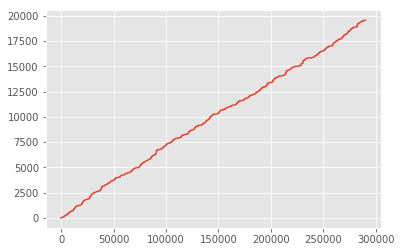

In [230]:
plot(points_dist_trav)

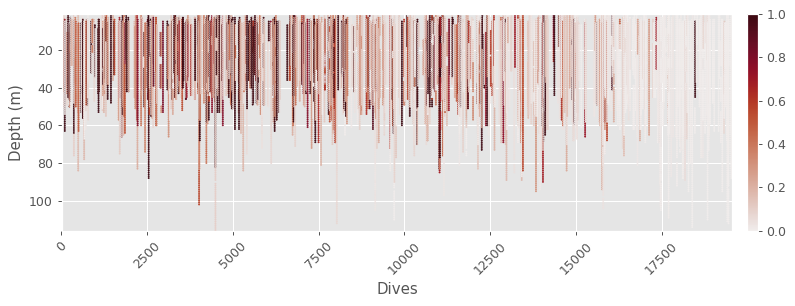

In [244]:
# Dist travelled
gt.plot.scatter(points_dist_trav,points_depths,values, cmap=cmo.amp, vmin=-0,vmax=1,s=1)
# Dist between
#gt.plot.scatter(points_dist_trav,points_depths,values, cmap=cmo.amp, vmin=-0,vmax=1,s=1)

In [243]:
#hbg_ = np.ma.masked_where(np.isnan(hbg_),hbg_)

In [251]:
hbg_[(hbg_<1)&(hbg_>0)].sel(delta_x=slice(0,50))

<xarray.DataArray (delta_x: 1126)>
array([0.045716, 0.207499, 0.096665, ..., 0.010818, 0.018077, 0.002756])
Coordinates:
    depths   int32 10
  * delta_x  (delta_x) float64 0.04428 0.0614 0.07724 0.1021 0.1238 0.1262 ...

Text(0.5,0,'delta_x [km]')

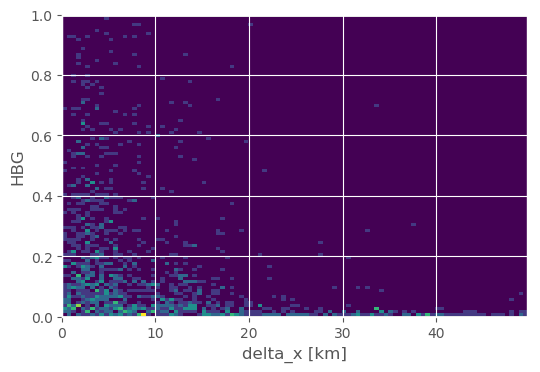

In [257]:
fig = plt.figure(dpi=100)
plt.hist2d(hbg_[(hbg_<1)&(hbg_>0)].sel(delta_x=slice(0,50)).delta_x.values,hbg_[(hbg_<1)&(hbg_>0)].sel(delta_x=slice(0,50)),bins=100)
plt.ylim(0,1)
plt.ylabel('HBG')
plt.xlabel('delta_x [km]')

In [253]:
for i,sealdata in tqdm_notebook(flr_gridded_xds1.groupby('sealID')):
    print(i)
    #print(sealdata)
    if i==13:
        #flr_gridded_xds2 = np.delete(sealdata,axis=1,obj=-1)
        flr_gridded_xds2 = sealdata.where(sealdata.Time!=sealdata.Time[-1], drop=True)
    else:
        #y = np.delete(sealdata,axis=1,obj=-1)
        y = sealdata.where(sealdata.Time!=sealdata.Time[-1], drop=True)
        flr_gridded_xds2 = xr.concat((flr_gridded_xds2,y),dim='x')


13
14
15
16
20
21
22
23
52
53
57
58
63
64
65
66
67
110
112
113



In [254]:
flr_gridded_xds2

<xarray.DataArray (depths: 200, x: 82509)>
array([[6.65, 6.7 , 6.7 , ...,  nan,  nan,  nan],
       [6.65, 6.7 , 6.7 , ...,  nan,  nan, 9.45],
       [6.65, 6.7 , 6.7 , ...,  nan,  nan, 9.45],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * depths   (depths) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * x        (x) MultiIndex
  - Time     (x) datetime64[ns] 2011-01-04T18:11:05 2011-01-04T18:17:05 ...
  - num      (x) float64 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 32.0 ...
  - sealID   (x) int64 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 ...
  - year     (x) int64 2011 2011 2011 2011 2011 2011 2011 2011 2011 2011 ...
  - lat      (x) float64 -46.92 -46.92 -46.92 -46.92 -46.92 -46.92 -46.92 ...
  - lon      (x) float64 38.43 38.43 38.43 38.43 38.43 38.43 38.43 38.43 ...
  - WE       (x) object 'East' 'East' 'East' 'East' 'Eas

## Case study

In [9]:
number=21
lat_coords = dives_pdsi[dives_pdsi.sealID==str(number)].lat.values
lon_coords = dives_pdsi[dives_pdsi.sealID==str(number)].lon.values
dist_trav = np.r_[gt.utils.distance(lon_coords, lat_coords).cumsum()]/1000
delta_x = gt.utils.distance(lon_coords, lat_coords)/1000
flr_gridded_xdsw_ = flr_gridded_xdsw.swap_dims({'Time': 'sealID'})

In [10]:
flr_gridded_xdsw_ = flr_gridded_xdsw_[:,flr_gridded_xdsw_.sealID==number]
flr_gridded_xdsw_ = flr_gridded_xdsw_.swap_dims({'sealID': 'Time'})
b_init_groups = flr_gridded_xdsw_.assign_coords(dist_trav=("Time", dist_trav)) 
b_init_groups = b_init_groups.assign_coords(delta_x=("Time", delta_x))
delta_x = b_init_groups.groupby("delta_x").reduce(nanmean,dim='Time').delta_x # This might not work because if a single distance repeats the arrays won't match up
b_init = b_init_groups.groupby("dist_trav").reduce(nanmean,dim='Time')
b_init = b_init.assign_coords(delta_x=("dist_trav", delta_x))

ValueError: conflicting sizes for dimension 'Time': length 7939 on 'dist_trav' and length 1 on 'Time'

In [9]:
xi = arange(0.5,ceil(b_init.dist_trav.values.max()),1) # 5km resolution
yi = arange(1,201,1).astype(numpy.float64)
points_dist_trav = np.tile(np.expand_dims(b_init.dist_trav,axis=1),(1,200)).ravel()
points_depths = np.tile(np.expand_dims(b_init.depths,axis=0),(1,b_init.shape[1])).ravel()
values = b_init.values.ravel(order='F')
#new_hbg_init = gt.grid_data(points_depths,points_dist_trav,values,bins=xi)

# hbg Calculation
i.e. Horizontal buoyancy gradient 

In [94]:
#%% Each dive/Time hbg

# Check if there is correlation between hbg and ht_rat and fsle. Do this for 50m, 5m, water column mean and 15m from max.d

g = 9.8
alpha = -0.000125
dpt = b_init.delta_x.values
hbg = np.apply_along_axis(calc_hbg,1,b_init)
hbg = hbg.squeeze()

In [98]:
hbg.shape

(200, 198)

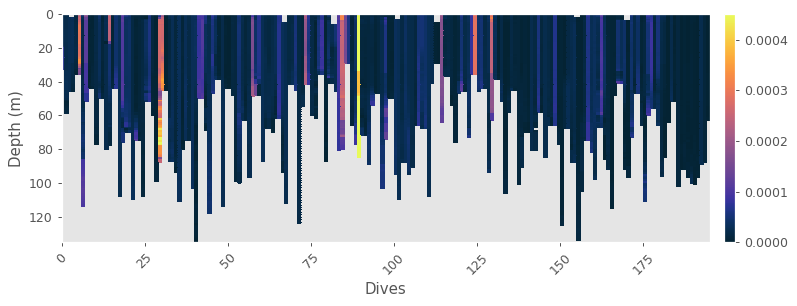

In [142]:
gt.plot(abs(hbg), cmap = cmo.thermal)# , vmin=-0.0004,vmax=0.004)

ValueError: x and y must have same first dimension, but have shapes (196,) and (198,)

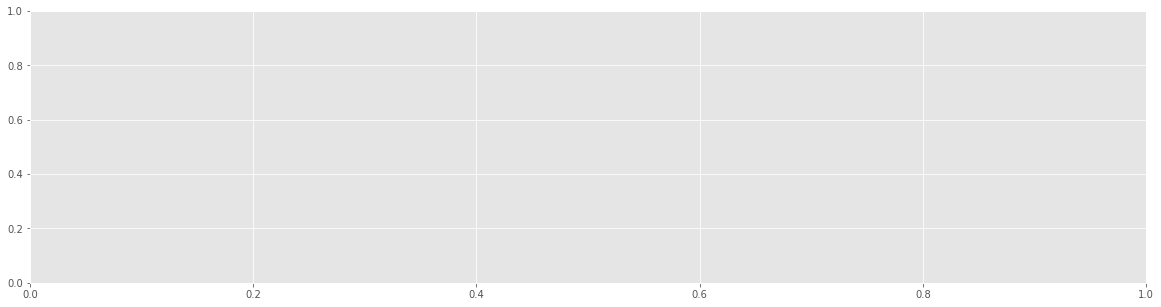

In [223]:
def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

fig = plt.figure(figsize=(20, 5))
HBG = movingaverage(abs(hbg[10,:]*1e5),1)
plt.plot(np.delete(dpt, 0),HBG)
plt.xlabel('Travel distance [km]')
plt.ylabel('horizontal buoyancy gradient [1e-5/sec^2]')

In [121]:
def drop_last(x):
    return (np.delete(x,axis=1,obj=-1))
drop_last(flr_gridded_xds)
flr_gridded_xds.groupby('sealID').apply(drop_last)

TypeError: 'DataArrayGroupBy' object is not subscriptable